<a href="https://colab.research.google.com/github/MitchellAcoustics/Soundscapy/blob/dev/docs/tutorials/IoA_Soundscape_Assessment_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!Rscript -e "install.packages('sn')"
!pip install "soundscapy[spi] @ git+https://github.com/MitchellAcoustics/Soundscapy@dev"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/sn_2.1.1.tar.gz'
Content type 'application/x-gzip' length 827061 bytes (807 KB)
downloaded 807 KB

* installing *source* package ‘sn’ ...
** this is package ‘sn’ version ‘2.1.1’
** package ‘sn’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (sn)

The downloaded source packages are in
	‘/tmp/Rtmprt6Poo/downloaded_packages’
  Cloning https://github.com/MitchellAcoustics/Soundscapy (to revision dev) to /tmp/pip-install-bg23ixf2/soundscapy_edf33d8197e942f5a12ac

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import soundscapy as sspy
from soundscapy import ISOPlot
from soundscapy.spi import DirectParams, MultiSkewNorm

# Set up plotting
warnings.filterwarnings("ignore")

# Soundscape Assessment Tutorial

## Introduction

This tutorial will guide you through the process of conducting a comprehensive soundscape assessment using Soundscapy. You'll learn how to analyze survey data, create visualizations, and interpret the results to understand how people perceive and experience soundscapes in different locations.

By the end of this tutorial, you'll be able to:
- Load and validate soundscape survey data
- Calculate ISO coordinates from perceptual attribute questions (PAQs)
- Create basic and advanced visualizations of soundscape data
- Perform statistical analysis of soundscape perceptions
- Apply the Soundscape Perception Index (SPI) to evaluate soundscapes against target distributions
- Create professional reports and presentations of your findings

Let's begin by loading some sample data and exploring its structure.

## 1. Loading and Exploring the Data

The first step in any soundscape assessment is to load and explore your data. For this tutorial, we'll use a sample dataset containing soundscape survey responses from multiple locations.

In [3]:
# Load the demo data
data = pd.read_excel("/content/DemoData.xlsx")

# Display the first few rows
data.head()

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,traffic_noise,other_noise,human_sounds,natural_sounds,...,LAeq,LA10,LA90,LCeq,N5,sharpness,roughness,tonality,ISOPleasant,ISOEventful
0,CamdenTown,CamdenTown1,CT101,525,2019-05-02 11:40:44,2019-05-02 11:43:24,4.0,3.0,3.0,2.0,...,69.93,72.43,64.67,77.85,30.8,2.09,0.0363,0.304,-2.196699e-01,0.426777
1,CamdenTown,CamdenTown1,CT101,526,2019-05-02 11:41:57,2019-05-02 11:44:21,3.0,1.0,2.0,1.0,...,69.93,72.43,64.67,77.85,30.8,2.09,0.0363,0.304,5.748368e-17,0.250000
2,CamdenTown,CamdenTown1,CT101,561,2019-05-02 11:40:44,2019-05-02 11:43:24,4.0,3.0,4.0,2.0,...,69.93,72.43,64.67,77.85,30.8,2.09,0.0363,0.304,-4.696699e-01,0.176777
3,CamdenTown,CamdenTown1,CT102,560,2019-05-02 11:50:10,2019-05-02 11:53:03,3.0,2.0,4.0,1.0,...,70.60,73.72,65.11,77.21,33.2,2.14,0.0430,0.252,1.035534e-01,-0.750000
4,CamdenTown,CamdenTown1,CT103,527,2019-05-02 11:49:06,2019-05-02 11:54:24,4.0,2.0,4.0,1.0,...,66.36,68.36,64.39,74.23,24.6,1.98,0.0367,0.184,2.500000e-01,0.750000


### Display basic information about the dataset

Dataset shape:

In [4]:
data.shape

(456, 37)

Number of locations:

In [5]:
data["LocationID"].nunique()

4

Locations:

In [6]:
data["LocationID"].unique()

array(['CamdenTown', 'MarchmontGarden', 'TateModern', 'PancrasLock'],
      dtype=object)

### Understanding the Data Structure

Our dataset contains several types of columns:

1. **Index Columns**: Identify the survey, location, and respondent
   - `LocationID`: Identifier for the location
   - `RecordID`: Identifier for the audio recording
   - `GroupID`: Identifier for the group of respondents
   - `SessionID`: Identifier for the survey session

2. **Perceptual Attribute Questions (PAQs)**: Ratings on a 5-point Likert scale
   - `PAQ1` (pleasant): How pleasant is the soundscape?
   - `PAQ2` (vibrant): How vibrant is the soundscape?
   - `PAQ3` (eventful): How eventful is the soundscape?
   - `PAQ4` (chaotic): How chaotic is the soundscape?
   - `PAQ5` (annoying): How annoying is the soundscape?
   - `PAQ6` (monotonous): How monotonous is the soundscape?
   - `PAQ7` (uneventful): How uneventful is the soundscape?
   - `PAQ8` (calm): How calm is the soundscape?

3. **Sound Source Dominance**: Ratings of how dominant different sound sources are
   - `traffic_noise`: Dominance of traffic noise
   - `other_noise`: Dominance of other mechanical noise
   - `human_sounds`: Dominance of human sounds
   - `natural_sounds`: Dominance of natural sounds

4. **Acoustic Metrics**: Objective measurements of the sound environment
   - `LAeq`: A-weighted equivalent continuous sound level
   - Various other metrics like `N5`, `Sharpness`, etc.

## 2. Data Validation and ISO Coordinate Calculation

Before analyzing the data, it's important to validate it to ensure quality and consistency. Soundscapy provides functions for validating soundscape data and calculating ISO coordinates.

In [7]:
# Validate the data
valid_data, invalid_indices = sspy.databases.isd.validate(data)

# Display validation results
print(f"Original dataset size: {len(data)}")
print(f"Valid dataset size: {len(valid_data)}")
print(f"Number of invalid records: {len(invalid_indices) if invalid_indices else 0}")

# If there are invalid records, display the first few
if invalid_indices:
    print("\nSample of invalid records:")
    print(data.loc[invalid_indices[:5]])

Original dataset size: 456
Valid dataset size: 456
Number of invalid records: 0


### Calculating ISO Coordinates

The ISO 12913 standard defines a circumplex model for soundscape perception, with two main dimensions: pleasantness and eventfulness. Soundscapy can calculate these coordinates from the PAQ responses with a single function call.

The ISO coordinates are calculated using a trigonometric projection of the eight PAQ responses, where:
- `ISOPleasant` represents the horizontal axis (pleasant to unpleasant)
- `ISOEventful` represents the vertical axis (eventful to uneventful)

These coordinates allow us to position each response in the soundscape circumplex model, which has four quadrants:
- Pleasant and Eventful: "Vibrant"
- Unpleasant and Eventful: "Chaotic"
- Unpleasant and Uneventful: "Monotonous"
- Pleasant and Uneventful: "Calm"

In [8]:
# Calculate ISO coordinates if not already present
valid_data = sspy.surveys.add_iso_coords(valid_data, overwrite=True)

# Display the first few rows with ISO coordinates
print("Data with ISO coordinates:")
valid_data[["LocationID", "ISOPleasant", "ISOEventful"]].head()

Data with ISO coordinates:


,LocationID,ISOPleasant,ISOEventful
0,CamdenTown,-2.196699e-01,0.426777
1,CamdenTown,5.748368e-17,0.250000
2,CamdenTown,-4.696699e-01,0.176777
3,CamdenTown,1.035534e-01,-0.750000
4,CamdenTown,2.500000e-01,0.750000


### Save the data

After using Soundscapy to calculate the ISOCoordinates, we can easily save our resulting DataFrame out to a file. We can easily save to an Excel file, allowing you to use the tools you're more comfortable with for additional analysis:

In [9]:
data.to_excel("SoundscapyResults.xlsx", index=False)

## 3. Basic Visualization and Summary Statistics

Now that we have our validated data with ISO coordinates, we can create basic visualizations and calculate summary statistics to understand the soundscape perceptions at different locations.

In [10]:
# Get summary statistics for ISO coordinates by location
iso_stats = valid_data.groupby("LocationID")[["ISOPleasant", "ISOEventful"]].agg(
    ["mean", "std", "min", "max"]
)

# Display the summary statistics
print("Summary statistics for ISO coordinates by location:")
iso_stats

Summary statistics for ISO coordinates by location:


ISOPleasant                               ISOEventful  \
                       mean       std       min       max        mean   
LocationID                                                              
CamdenTown        -0.102571  0.289155 -0.780330  0.603553    0.364096   
MarchmontGarden    0.276438  0.424521 -0.853553  1.000000   -0.036172   
PancrasLock        0.254416  0.390951 -0.750000  0.926777    0.078584   
TateModern         0.380585  0.288983 -0.426777  1.000000    0.210786   

                                               
                      std       min       max  
LocationID                                     
CamdenTown       0.344868 -0.750000  1.000000  
MarchmontGarden  0.258432 -0.500000  0.707107  
PancrasLock      0.284963 -0.707107  0.603553  
TateModern       0.308650 -0.676777  1.000000

### Create a circumplex scatter plot

Creating a scatter plot of the Soundscape data is extremely easy in Soundscapy. Let's start by plotting a single location. Again, we use `sspy.isd.select_location_ids()` to select a single location:

<Axes: title={'center': 'Soundscape Scatter Plot'}, xlabel='$P_{ISO}$', ylabel='$E_{ISO}$'>

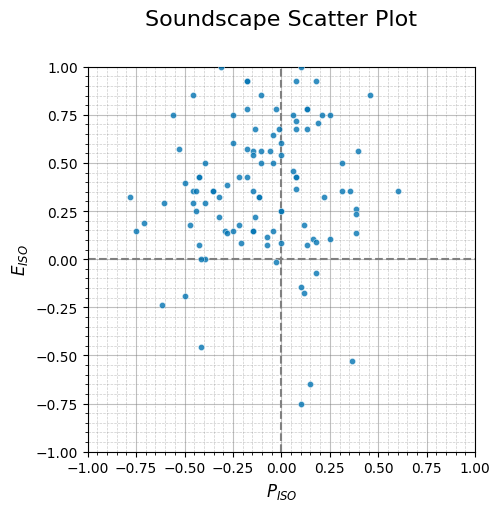

In [11]:
sspy.scatter(sspy.isd.select_location_ids(valid_data, "CamdenTown"))

#### Customizing the plot

The Soundscapy plotting functions contain several customization options, such as changing the color, palette, point size, and title:

<Axes: title={'center': 'Circumplex Scatter Plot of Soundscape Perceptions'}, xlabel='Pleasantness', ylabel='Eventfulness'>

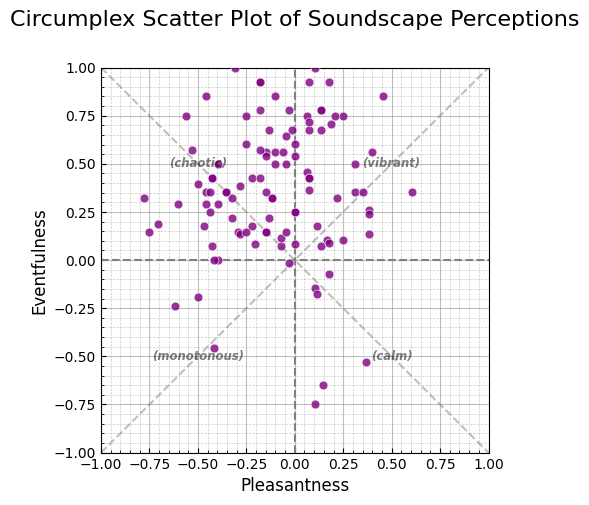

In [12]:
sspy.scatter(
    sspy.isd.select_location_ids(valid_data, "CamdenTown"),
    color="purple",
    s=40,
    title="Circumplex Scatter Plot of Soundscape Perceptions",
    xlabel="Pleasantness",
    ylabel="Eventfulness",
    diagonal_lines=True,
)

#### Color by location

One of the most useful settings is the ability to split the plot by some grouping variable. In Soundscape data, this will often be the location, but we can easily select any other categorical variable in the dataset. Simply set the `hue` option to get a different color for each group:

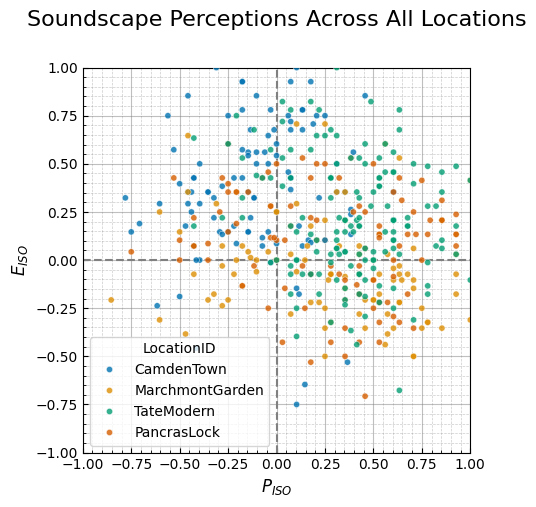

In [13]:
# Create a basic scatter plot of ISO coordinates
sspy.scatter(
    valid_data,
    title="Soundscape Perceptions Across All Locations",
    hue="LocationID",
)
plt.show()

TypeError: Data source must be a DataFrame or Mapping, not <class 'ellipsis'>.

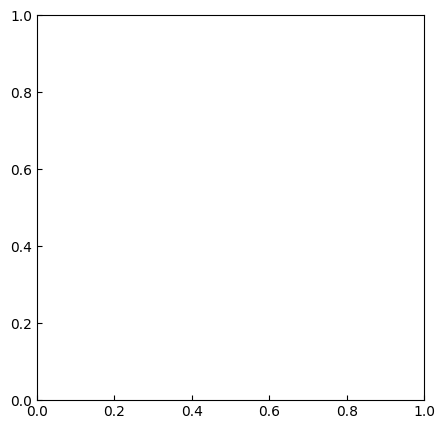

In [14]:
# Split by a different variable:

sspy.scatter(...)

## Density Plots

Of course, the most notable plot type in Soundscapy is the Density plot. Just like scatter, this has its own simple function. Try it out:

In [ ]:
# Create a basic density plot
sspy.density(...)
plt.show()

## 4. Creating Likert Style Plots

Likert plots are a useful way to visualize the distribution of responses to Likert scale questions, such as the PAQs in our survey. Soundscapy integrates with the `plot_likert` package to create these visualizations.

We can use Soundscapy's `paq_likert` plot to examine the distribution of PAQ responses:

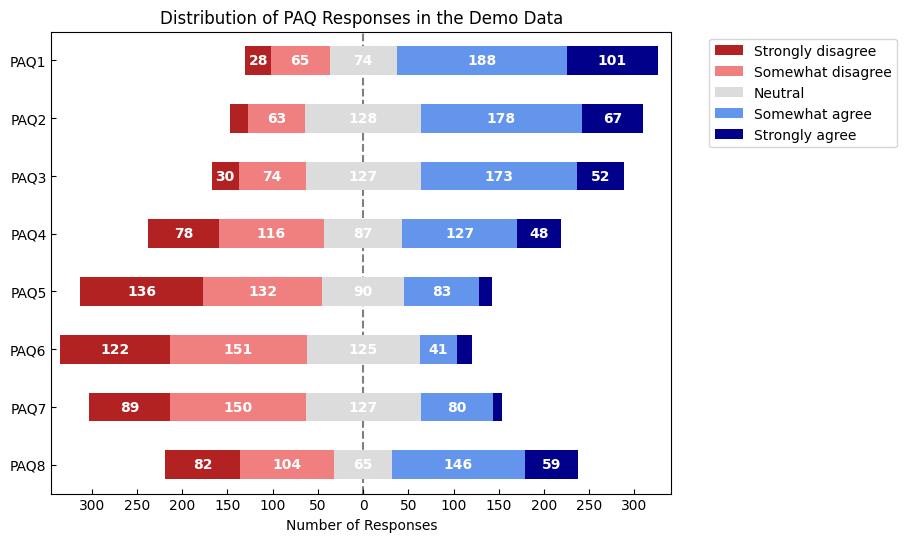

In [18]:
from soundscapy import PAQ_IDS

sspy.paq_likert(data[PAQ_IDS], title="Distribution of PAQ Responses in the Demo Data")

To get a better view of the data, we can also split it across the Locations. To do this, we use the `select_location_ids()` function from Soundscapy, and use a `for` loop to create a separate plot for each location.

In [ ]:
for location in data["LocationID"].unique():
    sspy.paq_likert(
        sspy.databases.isd.select_location_ids(data, location)[PAQ_IDS],
        title=f"Distribution of PAQ Responses in {location}",
    )
    plt.show()

### Analyzing Sound Source Dominance

Let's examine the dominance of different sound sources at each location.

In [ ]:
sspy.stacked_likert(valid_data, "traffic_noise", title="Traffic Noise Dominance")

Try this out with some of the other Likert scaled data:

In [ ]:
sspy.stacked_likert(...)

In addition to the more specialised Likert plots provided by Soundscapy, we can of course apply more common analyses. For this, we need to do some data processing and plotting in Pandas and Seaborn:

In [ ]:
# Calculate mean sound source dominance by location
sound_sources = (
    valid_data.groupby("LocationID")[
        ["traffic_noise", "other_noise", "human_sounds", "natural_sounds"]
    ]
    .mean()
    .round(2)
)

#### Mean sound source dominance by location:

In [ ]:
sound_sources

Since Soundscapy doesn't implement its own functionality for the more common plots, we fall back to the very nice Seaborn plotting library, which we imported as `sns` to create a barplot of the mean sound source responses (or you can of course do this in something like Excel):

In [ ]:
# Create a bar chart
sound_sources_plot = sound_sources.reset_index().melt(
    id_vars=["LocationID"], var_name="Source", value_name="Dominance"
)

sns.barplot(
    data=sound_sources_plot,
    x="Source",
    y="Dominance",
    hue="LocationID",
    palette="colorblind",
)
plt.title("Sound Source Dominance by Location")
plt.xlabel("Sound Source")
plt.ylabel("Mean Dominance Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Creating Complex Plots with Hue and Subplots

Soundscapy makes it easy to create more complex visualizations that show relationships between different variables. Let's explore how sound source dominance affects soundscape perception:

In [ ]:
# Create subplots showing the impact of natural sounds on soundscape perception
sspy.create_iso_subplots(
    data=valid_data,
    subplot_by="LocationID",
    hue="natural_sounds",
    plot_layers=["scatter", "simple_density"],
    title="Impact of Natural Sounds on Soundscape Perception",
)
plt.tight_layout()
plt.show()

In [ ]:
# Create subplots showing the impact of traffic noise on soundscape perception
sspy.create_iso_subplots(
    data=valid_data,
    subplot_by="LocationID",
    hue="traffic_noise",
    plot_layers=["scatter", "simple_density"],
    title="Impact of Traffic Noise on Soundscape Perception",
)
plt.tight_layout()
plt.show()

We can also examine the relationship between acoustic metrics and soundscape perception:

In [ ]:
# Create a scatter plot with regression line showing the relationship between LAeq and ISOPleasant
sns.lmplot(
    data=valid_data,
    x="LAeq",
    y="ISOPleasant",
    hue="LocationID",
    palette="colorblind",
    height=6,
    aspect=1.5,
)
plt.title("Relationship between Sound Level (LAeq) and Pleasantness")
plt.tight_layout()
plt.show()

In [ ]:
# Create a scatter plot with regression line showing the relationship between N5 and ISOEventful
sns.lmplot(
    data=valid_data,
    x="N5",
    y="ISOEventful",
    hue="LocationID",
    palette="colorblind",
    height=6,
    aspect=1.5,
)
plt.title("Relationship between Loudness (N5) and Eventfulness")
plt.tight_layout()
plt.show()

## 6. Applying SPI Analysis

The Soundscape Perception Index (SPI) is a powerful tool for comparing soundscapes to target distributions. It quantifies the similarity between two soundscape distributions on a scale from 0 to 100, where 100 indicates perfect similarity.

Let's define some target distributions and calculate SPI scores for our locations:

In [ ]:
# Define a "tranquil" target distribution
tranquil_target = DirectParams(
    xi=np.array([[0.8, -0.5]]),  # Pleasant and uneventful
    omega=np.array([[0.17, -0.04], [-0.04, 0.09]]),
    alpha=np.array([-8, 1]),
)

# Create a MultiSkewNorm instance from the parameters
tranquil_msn = MultiSkewNorm.from_params(tranquil_target)

# Generate sample data
tranquil_msn.sample(1000)

# Convert to DataFrame for visualization
tranquil_df = pd.DataFrame(
    tranquil_msn.sample_data, columns=["ISOPleasant", "ISOEventful"]
)

# Visualize the target distribution
plt.figure(figsize=(8, 8))
sspy.density(tranquil_df, title="Tranquil Target Distribution", color="red")
plt.show()

In [ ]:
# Define a "vibrant" target distribution
vibrant_target = DirectParams(
    xi=np.array([[0.7, 0.6]]),  # Pleasant and eventful
    omega=np.array([[0.15, 0.03], [0.03, 0.15]]),
    alpha=np.array([0, 0]),
)

# Create a MultiSkewNorm instance from the parameters
vibrant_msn = MultiSkewNorm.from_params(vibrant_target)

# Generate sample data
vibrant_msn.sample(1000)

# Convert to DataFrame for visualization
vibrant_df = pd.DataFrame(
    vibrant_msn.sample_data, columns=["ISOPleasant", "ISOEventful"]
)

# Visualize the target distribution
sspy.density(
    vibrant_df,
    title="Vibrant Target Distribution",
    color="purple",
)
plt.show()

Now let's calculate SPI scores for each location against both target distributions:

In [ ]:
# Calculate SPI scores for each location against the tranquil target
locations = valid_data["LocationID"].unique()
tranquil_spi_scores = {}
vibrant_spi_scores = {}

for location in locations:
    # Get data for this location
    location_data = sspy.databases.isd.select_location_ids(valid_data, location)

    # Calculate SPI against tranquil target
    tranquil_spi_scores[location] = tranquil_msn.spi_score(
        location_data[["ISOPleasant", "ISOEventful"]]
    )

    # Calculate SPI against vibrant target
    vibrant_spi_scores[location] = vibrant_msn.spi_score(
        location_data[["ISOPleasant", "ISOEventful"]]
    )

# Display the results
spi_results = pd.DataFrame(
    {
        "Tranquil SPI": tranquil_spi_scores,
        "Vibrant SPI": vibrant_spi_scores,
    }
).T

print("SPI Scores by Location:")
print(spi_results)

# Create a bar chart of SPI scores
plt.figure(figsize=(12, 6))
spi_results.plot(kind="bar", colormap="viridis")
plt.title("SPI Scores by Location")
plt.xlabel("Target Distribution")
plt.ylabel("SPI Score")
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.legend(title="Location")
plt.tight_layout()
plt.show()

## 7. Using the ISOPlot Interface for SPI Analysis

Soundscapy's `ISOPlot` class provides a more sophisticated interface for creating SPI visualizations. Let's use it to create a comprehensive SPI analysis:

In [ ]:
# Create an SPI plot comparing locations against the tranquil target
tranquil_plot = (
    ISOPlot(
        data=valid_data,
        title="Comparing Locations Against Tranquil Target",
    )
    .create_subplots(
        subplot_by="LocationID",
        figsize=(4, 4),
        auto_allocate_axes=True,
    )
    .add_scatter()
    .add_simple_density(fill=True)
    .add_spi(spi_target_data=tranquil_df, show_score="on axis")
    .style(legend_loc=False)
)

In [ ]:
# Create an SPI plot comparing locations against the vibrant target
vibrant_plot = (
    ISOPlot(
        data=valid_data,
        title="Comparing Locations Against Vibrant Target",
    )
    .create_subplots(
        subplot_by="LocationID",
        figsize=(4, 4),
        auto_allocate_axes=True,
    )
    .add_scatter()
    .add_simple_density(fill=True)
    .add_spi(spi_target_data=vibrant_df, show_score="on axis")
    .style(legend_loc=False)
)

## 8. Interpreting the Results

Now that we've analyzed our data and created various visualizations, let's interpret the results:

1. **Location Characteristics**:
   - Each location has a distinct soundscape character, as shown by its position in the circumplex model.
   - Some locations are more pleasant (higher ISOPleasant values), while others are more eventful (higher ISOEventful values).

2. **Sound Source Influence**:
   - Natural sounds tend to increase pleasantness, as shown by the relationship between natural sound dominance and ISOPleasant values.
   - Traffic noise tends to decrease pleasantness, as shown by the relationship between traffic noise dominance and ISOPleasant values.

3. **Acoustic Metrics**:
   - Higher sound levels (LAeq) are generally associated with lower pleasantness.
   - Higher loudness (N5) is generally associated with higher eventfulness.

4. **SPI Analysis**:
   - Some locations match better with the tranquil target, while others match better with the vibrant target.
   - This information can be used to identify which locations provide the desired soundscape experience.

These insights can inform soundscape design and management decisions, such as:
- Which locations to preserve or enhance for specific soundscape experiences
- Which sound sources to promote or mitigate at different locations
- How to design new spaces to achieve desired soundscape characteristics

## 9. Gallery of Soundscapy Visualizations

Soundscapy offers a wide range of visualization options. Here's a gallery of additional plots you can create:

In [ ]:
# Basic scatter plot
sspy.scatter(
    valid_data,
    title="Basic Scatter Plot",
    diagonal_lines=True,
)
plt.show()

In [ ]:
# Density plot
sspy.density(
    valid_data,
    title="Density Plot",
    diagonal_lines=True,
    fill=True,
)
plt.show()

In [ ]:
# Combined scatter and density plot
sspy.iso_plot(
    valid_data,
    title="Combined Scatter and Density Plot",
    plot_layers=["scatter", "density"],
    diagonal_lines=True,
)
plt.show()

In [ ]:
# Simple density plot with hue
sspy.density(
    valid_data,
    title="Simple Density Plot with Hue",
    density_type="simple",
    hue="LocationID",
)
plt.show()

In [ ]:
# Joint plot
sspy.jointplot(
    valid_data,
    title="Joint Plot",
)
plt.show()

In [ ]:
# Joint plot with histogram marginals
plt.figure(figsize=(10, 10))
sspy.jointplot(
    valid_data, title="Joint Plot with Histogram Marginals", marginal_kind="hist"
)
plt.show()

In [ ]:
# Joint plot with grouping
plt.figure(figsize=(10, 10))
sspy.jointplot(
    valid_data,
    title="Joint Plot with Grouping",
    hue="LocationID",
    density_type="simple",
)
plt.show()

In [ ]:
# Custom multi-panel visualization
fig = plt.figure(figsize=(15, 14))

# Create a 2x2 grid
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# Create a scatter plot of all locations in the first subplot
ax1 = fig.add_subplot(gs[0, 0])
sspy.scatter(
    valid_data,
    title="All Locations - Scatter",
    hue="LocationID",
    ax=ax1,
)

# Create a density plot of all locations in the second subplot
ax2 = fig.add_subplot(gs[0, 1])
sspy.density(
    valid_data,
    title="All Locations - Density",
    hue="LocationID",
    density_type="simple",
    incl_scatter=False,
    fill=False,
    ax=ax2,
)

# Create a scatter plot colored by LAeq in the third subplot
ax3 = fig.add_subplot(gs[1, 0])
sspy.scatter(
    valid_data,
    title="Sound Level (LAeq)",
    hue="LAeq",
    palette="viridis",
    ax=ax3,
)

# Create a density plot colored by natural sounds in the fourth subplot
ax4 = fig.add_subplot(gs[1, 1])
sspy.density(
    valid_data,
    title="Natural Sounds Dominance",
    hue="natural_sounds",
    density_type="simple",
    ax=ax4,
)

plt.tight_layout()
plt.show()

## 10. Summary

In this tutorial, you've learned how to:

1. **Load and validate soundscape survey data**
   - Import data from Excel files
   - Validate data quality
   - Calculate ISO coordinates

2. **Create basic visualizations and summary statistics**
   - Scatter plots and density plots
   - Summary statistics by location
   - Sound source dominance analysis

3. **Create Likert style plots**
   - Convert numeric responses to categorical
   - Create side-by-side Likert plots for comparison

4. **Create complex plots with hue and subplots**
   - Visualize relationships between variables
   - Create multi-panel visualizations
   - Analyze the impact of sound sources on perception

5. **Apply SPI analysis**
   - Define target distributions
   - Calculate SPI scores
   - Compare locations against different targets

6. **Use the ISOPlot interface**
   - Create sophisticated SPI visualizations
   - Combine multiple layers in a single plot
   - Customize plot appearance

These skills will enable you to conduct comprehensive soundscape assessments and communicate your findings effectively. By understanding how people perceive and experience soundscapes, you can contribute to the design and management of more pleasant and appropriate acoustic environments.

## References

1. ISO 12913-1:2014. Acoustics — Soundscape — Part 1: Definition and conceptual framework.
2. ISO 12913-2:2018. Acoustics — Soundscape — Part 2: Data collection and reporting requirements.
3. ISO 12913-3:2019. Acoustics — Soundscape — Part 3: Data analysis.
4. Mitchell, A., Aletta, F., & Kang, J. (2022). How to analyse and represent quantitative soundscape data. JASA Express Letters, 2, 37201. https://doi.org/10.1121/10.0009794